In [1]:
#1. Import some libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Import Seaborn
import seaborn as sns
# This allows plots to appear on the IPython notebook.
%matplotlib inline
import matplotlib.cm as cm # import the colormap library
import operator

#2. Read dataframe "route_edges_am"
df = pd.read_csv("data/riyadh_route_edges_am.txt", sep=" ", index_col=0)
##df["travel_time"].head(2)
df.head(1)

#3. Let's define an empty undirected graph "RG".
RG = nx.Graph()
# We also define the values dictionary for the "edge attributes"
keys = ['volume', 'capacity', 'voc', 'degree', 'free_travel_time', 'travel_time']
for row in df.itertuples(index=False):    
    values = row[2:]    
    # We create a dictionary "edge_attributes" with the keys and row values
    edge_attributes = dict(zip(keys, values))    
    my_tuple = (row[0], row[1])   
    # We add the edge to the graph use "add_edge" function
    RG.add_edge(*my_tuple, attr_dict=edge_attributes)

#3.1 ******How to call nodes, edges, and their attributes******************************************
#print "*1. "+str(RG.edges(1))     # call all edges starting from node_1
#print "*2. "+str(RG.nodes()[:3])  # call first 3 nodes 
#print "*3. "+str(RG.edges()[:5]) + "**" + str(RG.edges()[3:5])
#print "*4. "+str(RG[1][2])   # call edge (1,2)
#print "*5. "+str(RG[1][2]["travel_time"]) +" "+ str(RG[2][1]["travel_time"]) # call edge (1,2) attribute "travel_time"
#print "*6. "+str(RG.node[1]) # call node_1 attributes

#4. Read dataframe of node with coordinates
nodes_df = pd.read_csv("data/riyadh_nodes.txt", sep=" ", index_col=0)
nodes_df.head(1)

#5. Adding coordinates to nodes in nx.Graph() RG
for node_id in RG.nodes():
    ##df.loc[row_indexer,column_indexer]; df.loc[x,y] is a locator look for certain row x and column y
    ##loc_dict[node_id] = (float(nodes_df.loc[[node_id]]['st_x']), float(nodes_df.loc[[node_id]]['st_y']))
    # or the other way round, just simply call the dataframe by column name and row number
    RG.node[node_id]["coordinate"] = (nodes_df['st_x'][node_id], nodes_df['st_y'][node_id])

#print RG.node[1]                # call attribute dictionary of node_1
#print RG.node[1]["coordinate"]  # call value of key coordinate of node_1

#6. Read dataframe of foursquareCheckinNodes.csv
fsq_nodes = pd.read_csv('data/FoursqureCheckinNodes.csv', sep=",")
#print fsq_nodes["NAME"][:3]
#print fsq_nodes["NAME"][0]
ID = fsq_nodes['ID']
NAME = fsq_nodes['NAME']
CATEGORY = fsq_nodes['CATEGORY']
CHECKIN = fsq_nodes['CHECK-IN']
LAT = fsq_nodes['LAT']
LONG = fsq_nodes['LONG']
#print len(ID), len(LAT)

#7. Now we build a Graph "fsq_G" to store the checkin points for foursqure
FSQ = nx.Graph()
coordinate_fsq = []
# We also define the values dictionary for the "node attributes"
for i in range(len(ID)):
        coordinate_fsq.append((LONG[i], LAT[i]))
        FSQ.add_node(i, fsq_id = ID[i],
                       coordinate = ((LONG[i], LAT[i])), checkin = CHECKIN[i], name = NAME[i], category = CATEGORY[i])

#8. **Now we build a new dictionary dict_checkin to sort maximum checkin point**
dict_checkin = {}
for i in FSQ.nodes():
    dict_checkin[i] = FSQ.node[i]["checkin"]    
sorted_checkin = sorted(dict_checkin.items(), key = operator.itemgetter(1))
sorted_checkin.reverse()
MAX=[]

#9. **Here we define the first X maximum checkin nodes to use**
for i in range(len(FSQ.nodes())): 
    MAX.append(FSQ.node[sorted_checkin[i][0]]) # Maximum checkin node
print MAX[:3]
#print "\n"

[{'coordinate': (46.674771309999997, 24.711632550000001), 'category': 'Coffee Shop', 'checkin': 93420, 'fsq_id': '4bb78b8f3db7b7139222209a', 'name': 'Kingdom Centre | \xaa\xc4\xbf\xb1\xaa\xdb\xbf_ \xbf_\xaa\xdc\xaa\xc4\xaa\xc4\xaa\xdc\xaa\xdb\xbf\xa9'}, {'coordinate': (46.683923010000001, 24.697129180000001), 'category': 'Coffee Shop', 'checkin': 73327, 'fsq_id': '4c892e4897828cfa5630a2aa', 'name': 'Centria | \xbf_\xaa\xe6\xbf\xe9\xbf\xb1\xaa_\xbf_'}, {'coordinate': (46.670182740000001, 24.69228232), 'category': 'Mall', 'checkin': 61518, 'fsq_id': '4eaac9cecc217eb08e78c735', 'name': 'Panorama Mall | \xbf\xe5\xbf_\xaa\xe6\xaa_\xbf\xb1\xbf_\xaa\xc4\xbf_ \xaa\xc4\xaa_\xaa\xdc'}]


In [2]:
#10. ********************Now we found the nearest nodes to the maximun checkin nodes
start_list = []
for i in MAX: # change back to MAX when need to rank nodes
    #print i['coordinate']
    dist_fsq = {}
    for node_id in RG.nodes():
        dist_fsq[node_id] = round(abs(i['coordinate'][0] -RG.node[node_id]["coordinate"][0])
        +abs(i['coordinate'][1] -RG.node[node_id]["coordinate"][1]),6)
    tmp_sort= sorted(dist_fsq.items(), key = operator.itemgetter(1))
    start_list.append(tmp_sort[0][0])
print "starting nodes are: " + str(start_list[:20])

#10. ******** Now we add the nearest node id to the FSQ.Graph()
#print FSQ.node[0]
for i in range(len(start_list)):
    FSQ.node[i]['closest_node']= start_list[i]
#print FSQ.node[0]

#11. Now we plot the FSQ node graphy
fsq_sizes = [FSQ.node[u]["checkin"]*0.002 for u in FSQ.nodes()]
# plt.cm.coolwarm() is a function change value to color from cool-warm
fsq_colors = plt.cm.coolwarm(np.log(np.log(fsq_sizes)))
loc_fsq = {}
for node_index in FSQ.nodes():
    ##print node_index
    loc_fsq[node_index] = FSQ.node[node_index]["coordinate"]    
#plt.figure(figsize=(10,20))
#nx.draw(FSQ, pos=loc_fsq, node_size=fsq_sizes, node_color=fsq_colors);
#nx.draw_networkx_labels(FSQ, pos=loc_fsq, label_size = 1); # semicolon suppresses output
#print FSQ.node[446]

starting nodes are: [7601, 5808, 4590, 8716, 8960, 1274, 7546, 10084, 1062, 746, 7565, 3317, 4374, 6585, 705, 7408, 8716, 745, 6677, 7935]


In [3]:
#12. *******Now we caculate the Manhattan District Algorithm*****
import operator
import math
print "checkin points amount is: " + str(len(start_list))
start_node = [start_list[19]] #******************************************** Which node to start***********************
distance = {}
for i in start_node:
    for node_id in RG.nodes():
        x1=RG.node[i]["coordinate"][0]
        y1=RG.node[i]["coordinate"][1]
        x2=RG.node[node_id]["coordinate"][0]
        y2=RG.node[node_id]["coordinate"][1]
        distance[node_id] = math.sqrt(math.pow((x1-x2),2)+math.pow((y1-y2),2))
#print distance
print "Now we caculate shortest paths from start_node: " + str(start_node[0])
# *******Now we sort the distance by Manhattan District algorithm, and have a sorted list "end_list"
sorted_distance = sorted(distance.items(), key = operator.itemgetter(1))
#print sorted_distance[:5]
#print sorted_distance[2][0]
end_list = []
for i in sorted_distance:
    end_list.append(i[0])
#print len(end_list)

#12 Analysis the degrees, and centrality use "nx.degree()" and "nx.degree_centrality" function        
degrees = nx.degree(RG)
centralities= nx.degree_centrality(RG)
# degrees, centralities are dictionary, we need to call their all values as new lists
node_centrality=[round((centralities[u]*10000),2) for u in centralities]
node_degree = [i for i in degrees.values()]

#print node_centrality
#print node_degree
#print "Done with process"

#13. ****Right way to call edge, node attributes as visualization reference****
# colors = [G[u][v]['color'] for u,v in edges]
# weights = [G[u][v]['weight'] for u,v in edges]
# nx.draw(G, pos, edges=edges, edge_color=colors, width=weights)
node_colors = range(len(RG.nodes())) # plt.cm.coolwarm() is a function change value to color from cool-warm
node_sizes = node_centrality
edges = RG.edges()
weights = [RG[u][v]["volume"]*0.0009 for u,v in edges]
edge_colors = plt.cm.coolwarm(np.log(np.log(weights))) # remember to import the colormap library first
loc_dict = {}
for node_index in RG.nodes():
    ##print node_index
    loc_dict[node_index] = RG.node[node_index]["coordinate"]
    
#14. If I pick any two intersections, is it possible to find a route
# between them? Check if the network is connected.
print "*Is the road network connected? "+ str(nx.is_connected(RG))

#15. use nx.dijkstra_path(G,node_start,node_end, weight) to caculate shortest paths
import json
scope = 3000
for start in start_node:
    ##print "*1. Start Node: " + str(start) 
    path_dict = {start:[]}
    for end in end_list[:scope]:  # [:x] control how many nodes in loop as end_point
        try:
            short_path = nx.dijkstra_path(RG, start, end, weight='travel_time')
            path_dict[start].append({end:short_path})
            ##print "*1.1 [start, End]: " + str([start, end])
            ##print "*1.2 Shortest path is: "+str(short_path)
            ##print "*1.3 Record dictionary is: "+str(path_dict)
            ##print "\n"
        except:
            pass
    ##print path_dict
    with open("TXT/"+str(start)+".txt", "w") as text_file:
        text_file.write(json.dumps(path_dict))
        print "Done writting txt flie with Start Node: " + str(start) + "\n"
#print path_dict

checkin points amount is: 448
Now we caculate shortest paths from start_node: 7935
*Is the road network connected? True
Done writting txt flie with Start Node: 7935



In [21]:
#!/usr/bin/env python
# Haversine formula example in Python
# Author: Wayne Dyck

# import math
# def distance2(origin, destination):
#     lat1, lon1 = origin
#     lat2, lon2 = destination
#     radius = 6371 # km

#     dlat = math.radians(lat2-lat1)
#     dlon = math.radians(lon2-lon1)
#     a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
#         * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
#     c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
#     d = radius * c
#     return d
# X1=(24.71163255,46.67477131)
# X2= (24.69712918,46.68392301)
# distance2(X1,X2)

#16. Before Shortest_RG, let's define a function degree2km to transfer the units and caculate the distance
import math
def degree2km(origin, destination):
    lat1, lon1 = RG.node[origin]['coordinate']
    lat2, lon2 = RG.node[destination]['coordinate']
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

print RG.node[5]['coordinate']
degree2km(1,2)

(46.762446107686998, 24.718756646097301)


0.14540258317389218

In [37]:
#16. Let's define a new empty undirected graph "Shortest_RG".
Shortest_RG = nx.Graph()

sum_time = {}
sum_dist = {}
tmp_edges = []

for i in start_node:
    for j in range(len(path_dict[i])):        
        tmp_dict= path_dict[i][j]
        tmp= tmp_dict.values()
        tmp_list= tmp[0]
        #print "1* i="+str(i) + ", j="+str(j)+ ", "+str(tmp_dict)+", list length="+str(len(tmp_list))        
        time_list = []
        dist_list = []
        if len(tmp_list) > 1:
            for x in range(len(tmp_list)-1):
                o_id = tmp_list[x]
                d_id = tmp_list[x+1]
                ##print o_id, d_id                    
                time_list.append(round(RG[o_id][d_id]["travel_time"],2)) 
                dist_list.append(round(degree2km(o_id,d_id),2))
                tmp_sum_time = round(sum(time_list),2)
                tmp_sum_dist = round(sum(dist_list),2)
                if tmp_sum_time < 50: ##############################
                    sum_time[(o_id,d_id)] = tmp_sum_time
                    sum_dist[(o_id,d_id)] = tmp_sum_dist
                    new_edge_attr = RG[o_id][d_id]
                    ##print new_edge_attr
                    ##Shortest_RG.add_edge(*(o_id,d_id), attr_dict= new_edge_attr)
                    Shortest_RG.add_edge(*(o_id,d_id), subtime=round(new_edge_attr['travel_time'],2))
                    Shortest_RG[o_id][d_id]["sum_time"]= round(sum(time_list),2)
                    Shortest_RG[o_id][d_id]["sum_dist"]= round(sum(dist_list),2)
                    ##print "2* time_list= " +str(time_list)
                    ##print "3* sum_time= " +str(sum_time)
        ##print "\n"
print "Done with Caculation: " + str(start_node[0])
print Shortest_RG.edges()[:3]
print Shortest_RG.edge[3][10616]

Done with Caculation: 7935
[(3, 10616), (3, 4), (4, 9056)]
{'sum_dist': 6.73, 'subtime': 0.11, 'sum_time': 6.24}


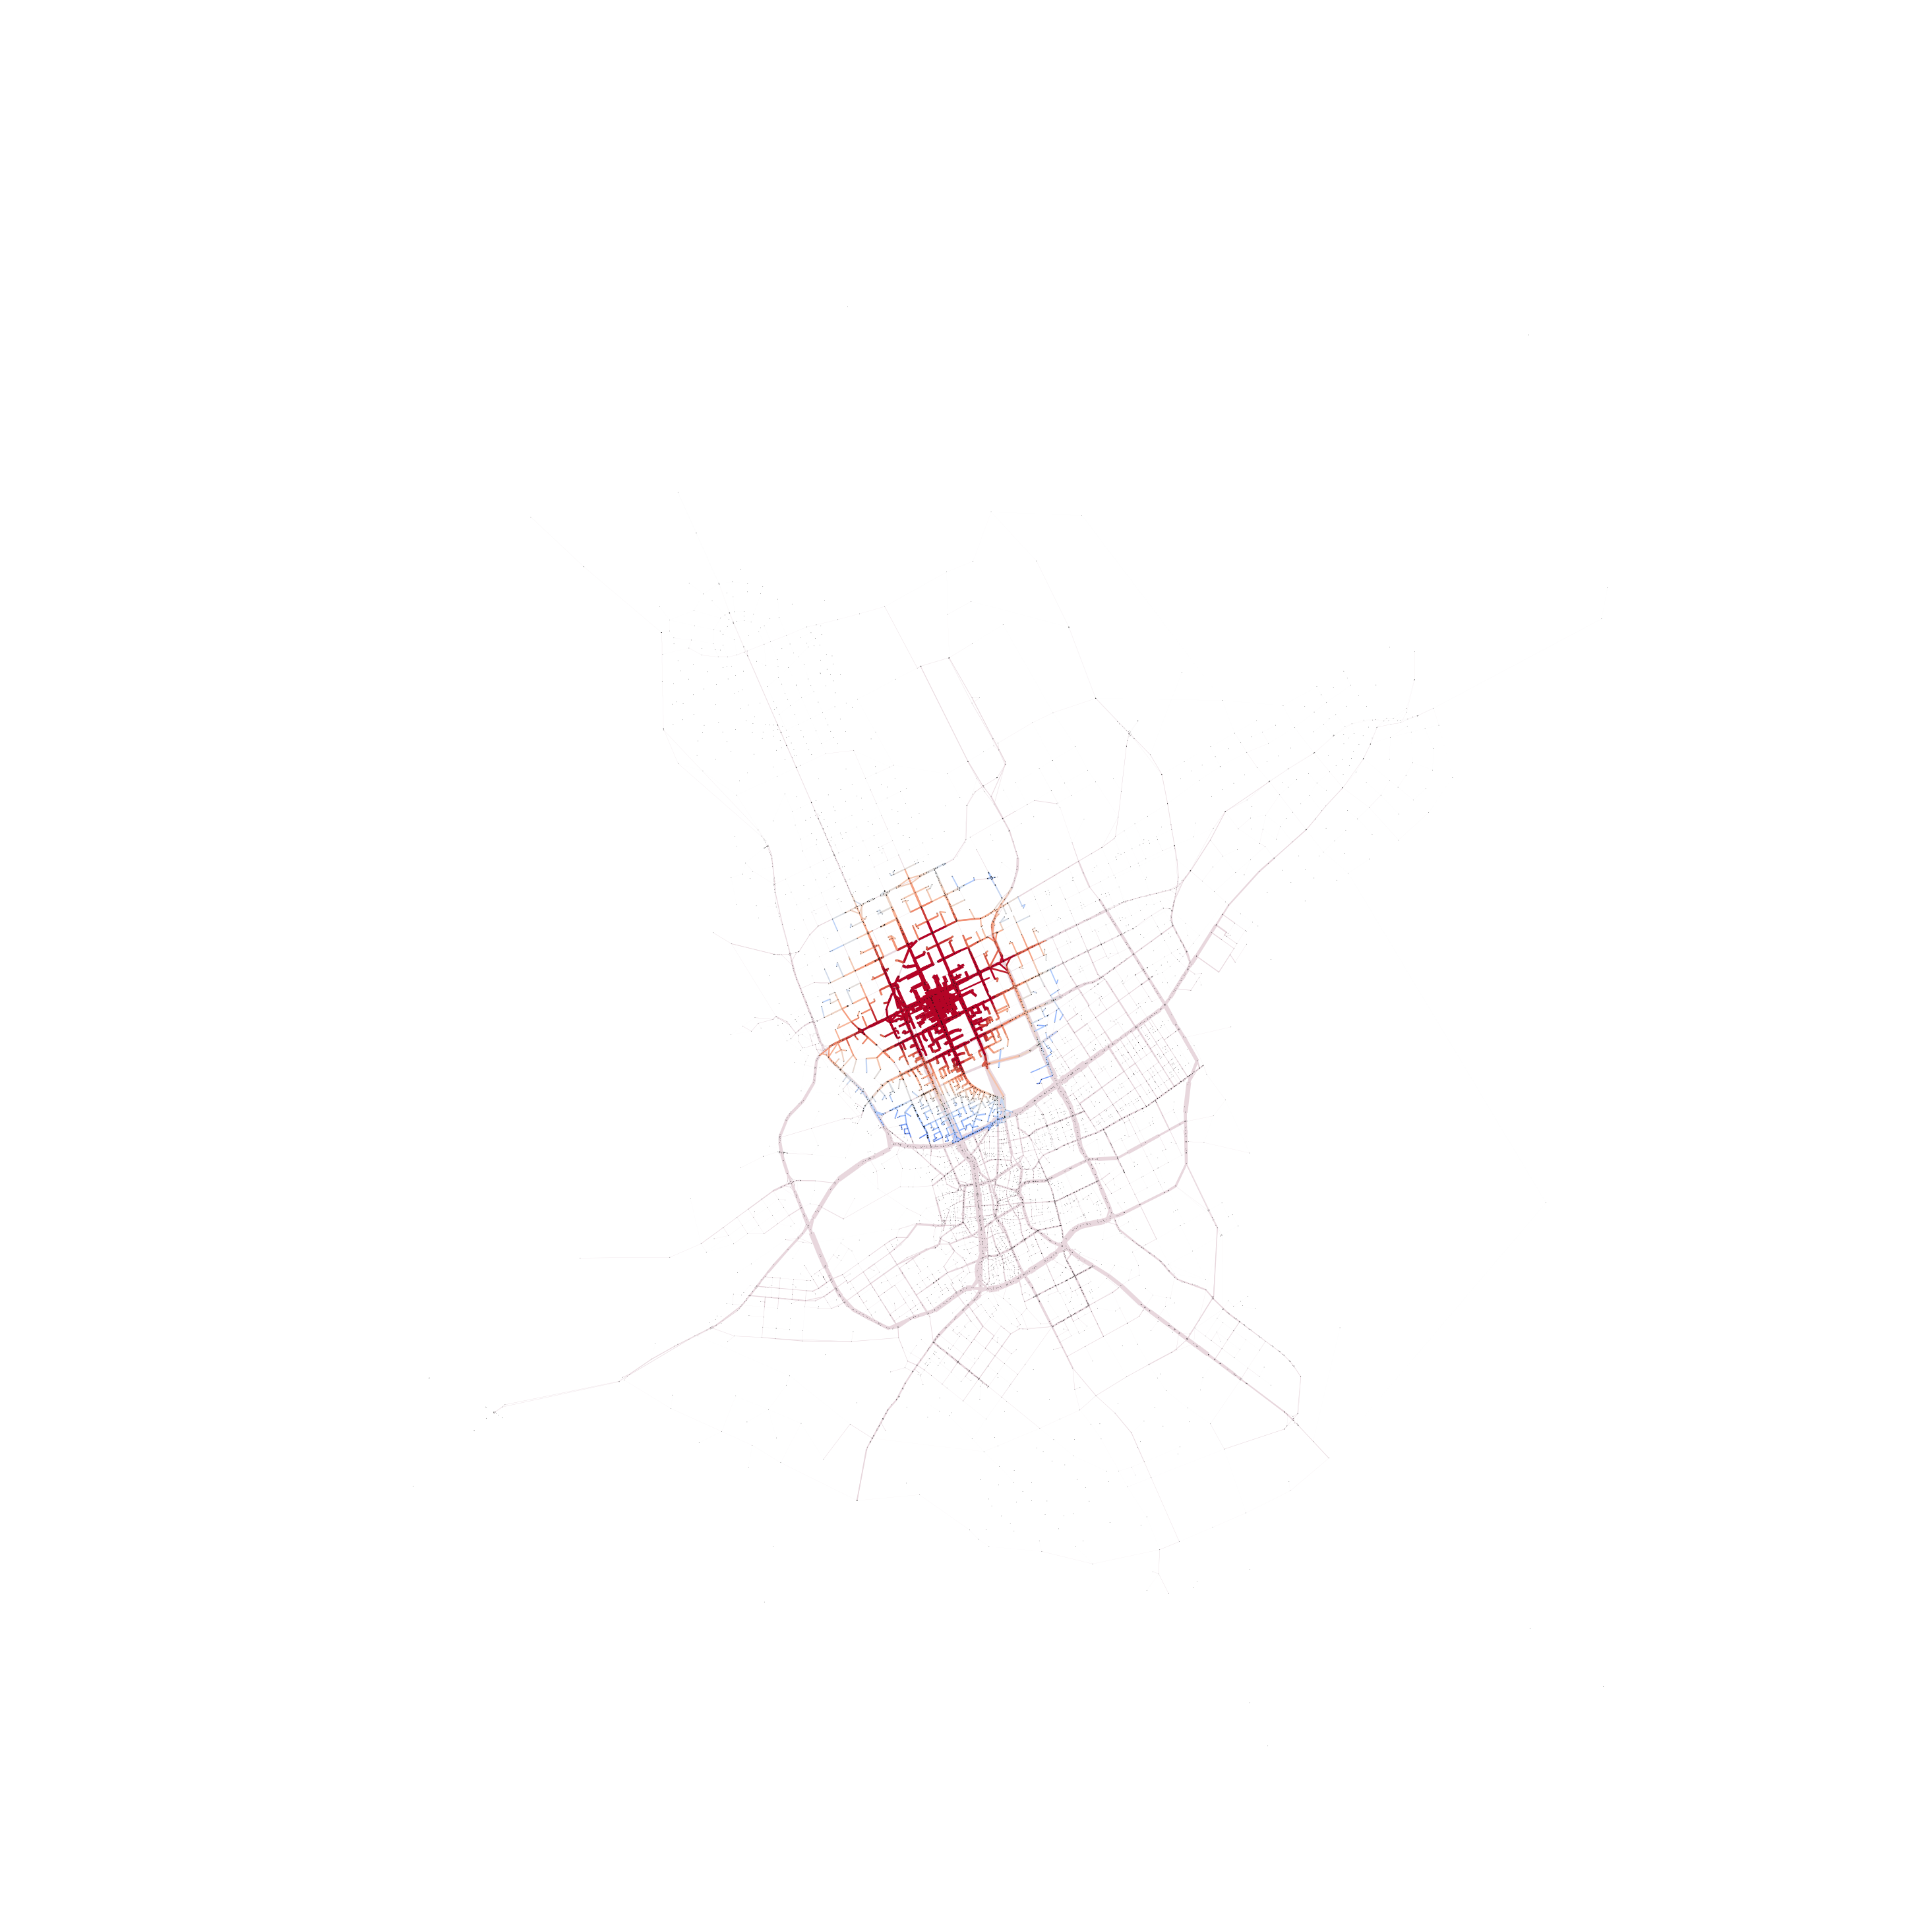

In [34]:
#17. Now we can add node coordinates
loc_dict_sh = {}
for node_index in Shortest_RG.nodes():
    ##print node_index
    loc_dict_sh[node_index] = RG.node[node_index]["coordinate"]
    Shortest_RG.node[node_index]["coordinate"] = RG.node[node_index]["coordinate"]
    ##print loc_dict[node_index]
    
#18. Now plot the comprehensive map

degrees_sh = nx.degree(Shortest_RG)
node_sizes_sh = []
for i in Shortest_RG.nodes():
    node_sizes_sh.append(degrees_sh[i])

node_colors_sh = range(len(Shortest_RG.nodes()))

edges_sh = Shortest_RG.edges()
weights_time = [15/Shortest_RG[u][v]["sum_time"] for u,v in edges_sh]
weights_time_2 = [u+0.5 for u in weights_sh]
weights_dist = [15/Shortest_RG[u][v]["sum_dist"] for u,v in edges_sh]
weights_dist_2 = [u+0.5 for u in weights_dist]
#edge_colors = [Shortest_RG[u][v]["volume"] for u,v in edges]
edge_colors_sh = plt.cm.coolwarm(np.log(weights_sh))

##print node_sizes
##print node_colors
##print edges
##print weights
##print edge_colors

plt.figure(figsize=(40,40))
##nx.draw(FSQ, pos=loc_fsq, node_size=fsq_sizes, node_color=fsq_colors);
nx.draw(RG, pos=loc_dict, node_size=0.1, width=weights, node_color=node_colors, edge_color = "#e8d7dd");
nx.draw(Shortest_RG, pos=loc_dict_sh, 
        node_size=0.2, node_color=node_colors_sh, width=weights_dist_2, edge_color=edge_colors_sh);
#nx.draw_networkx_labels(Shortest_RG,pos=loc_dict); # semicolon suppresses output

In [29]:
#print Shortest_RG.edge[8193][3488]
#print Shortest_RG.edge[3488][8193]
#print Shortest_RG.edges()[:3]
#print Shortest_RG.node[8193]

#19. Now construct the multi-tier dictionary structures.
# Build the 1st tier dictionary, called \"geoDataSet\".\n",
geoDataSet  = {}
geoDataSet["type"] = "FeatureCollection"
geoDataSet["features"] = []

for i in Shortest_RG.edges():   
    id_o = i[0]
    id_d = i[1]
    tmp_dict = {}
    tmp_dict["type"] = "Feature"
    tmp_dict["properties"]= Shortest_RG.edge[id_o][id_d]
    tmp_dict["geometry"] = {}
    tmp_dict["geometry"]["type"] = "LineString"
    tmp_x1 = Shortest_RG.node[id_o]['coordinate'][0]
    tmp_y1 = Shortest_RG.node[id_o]['coordinate'][1]
    tmp_x2 = Shortest_RG.node[id_d]['coordinate'][0]
    tmp_y2 = Shortest_RG.node[id_d]['coordinate'][1]
    tmp_dict["geometry"]["coordinates"] = [[tmp_x1,tmp_y1],[tmp_x2,tmp_y2]]                  
    geoDataSet["features"].append(tmp_dict)

#20. dump geoDataSet to json

with open("data/json/"+str(start_node[0])+"_"+str(scope)+".json", "w") as text_file:
    text_file.write(json.dumps(geoDataSet))
    print "Done writting JSON file with Start Node: " + str(start) + "\n"

Done writting JSON file with Start Node: 7935



In [8]:
#21. Now construct the multi-tier dictionary structures for foursquare checkin points.
import json
print FSQ.node[1]

geoDataSet  = {}
geoDataSet["type"] = "FeatureCollection"
geoDataSet["features"] = []

for i in FSQ.nodes():       
    tmp_dict = {}
    tmp_dict["properties"]={}
    tmp_dict["type"] = "Feature"
    tmp_dict["properties"]["category"]= FSQ.node[i]['category']
    tmp_dict["properties"]["checkin"]= FSQ.node[i]['checkin']
    tmp_dict["properties"]["id"]= FSQ.node[i]['fsq_id']
    tmp_dict["properties"]["closest_node"]= FSQ.node[i]['closest_node']
    tmp_dict["geometry"] = {}
    tmp_dict["geometry"]["type"] = "Point"
    tmp_x1 = FSQ.node[i]['coordinate'][0]
    tmp_y1 = FSQ.node[i]['coordinate'][1] 
    tmp_dict["geometry"]["coordinates"] = [tmp_x1,tmp_y1]                 
    geoDataSet["features"].append(tmp_dict)
#22. dump geoDataSet to json
with open("Json/"+"fsq_checkin"+".json", "w") as text_file:
    text_file.write(json.dumps(geoDataSet))
    print "Done writting with Nodes: " + "Foursquare Checkin Json" + "\n"

{'category': 'Coffee Shop', 'name': 'Centria | \xbf_\xaa\xe6\xbf\xe9\xbf\xb1\xaa_\xbf_', 'checkin': 73327, 'fsq_id': '4c892e4897828cfa5630a2aa', 'coordinate': (46.683923010000001, 24.697129180000001), 'closest_node': 5808}
Done writting with Nodes: Foursquare Checkin Json



In [68]:
#*************Combine json files to one huge Json*****************************************************************

from os import listdir
from os.path import isfile, join
import json
onlyfiles = [f for f in listdir("data/json/") if isfile(join("data/json/", f))]

all_json = {}
for f in onlyfiles:
    if f.endswith('.json'):
        node_index = f[:f.index('.')]
        with open("data/json/"+f, "r") as text_file:
            text_content = text_file.read()
            eq_index = text_content.index('{')
            this_json = json.loads(text_content[eq_index:])
            all_json[node_index] = this_json            

with open("data/json/some/all_nodes.json", "w") as text_file:
    text_file.write('var all_json='+json.dumps(all_json))
    print "Done writting JSON file with Start Node: " + str(start) + "\n"

Done writting JSON file with Start Node: 7935

